# 全体の流れ

1. スクレイピング
2. 形態素解析(MeCab)
3. nlplot

# 1. スクレイピング

In [ ]:
! pip install selenium

In [60]:
import json
import re
import time

import pandas as pd
import requests
from bs4 import BeautifulSoup as bs4
from selenium import webdriver

base_url = 'https://www.wantedly.com'


def scrape_path(url):
    """
    ストーリー一覧ページからスペース詳細ページのURLを取得する

    Parameters
    --------------
    url: str
        ストーリー一覧ページのURL

    Returns
    ----------
    path_list: list of str
        スペース詳細ページのURLを格納したリスト
    """

    path_list = []

    response = requests.get(url)
    soup = bs4(response.text, 'lxml')
    time.sleep(3)

    # <script data-placeholder-key="wtd-ssr-placeholder"> の中身を取得
    # json文字で、先頭の'//'を除去するため.string[3:]
    feeds = soup.find('script', {'data-placeholder-key': 'wtd-ssr-placeholder'}).string[3:]
    feed = json.loads(feeds)

    # {'body'}の'spaces'を取得
    feed_spaces = feed['body'][list(feed['body'].keys())[0]]['spaces']
    for i in feed_spaces:
        space_path = base_url + i['post_space_path']
        path_list.append(space_path)

    return path_list


path_list = scrape_path('https://www.wantedly.com/companies/exidea/feed')


def scrape_url(path_list):
    """
    スペース詳細ページからストーリー詳細ページのURLを取得する

    Parameters
    --------------
    path_list: list of str
        スペース詳細ページのURLを格納したリスト

    Returns
    ----------
    url_list: list of str
        ストーリー詳細ページのURLを格納したリスト
    """

    url_list = []

    # chromeを起動(chromedriverはこのファイルと同じディレクトリに配置)
    driver = webdriver.Chrome('chromedriver')
    for feed_path in path_list:
        driver.get(feed_path)

        # ページ下部までスクロールして、これ以上スクロールできなくなったらプログラム終了
        # スクロール前の高さ
        last_height = driver.execute_script("return document.body.scrollHeight")

        while True:
            # ページ下部までスクロール
            driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')

            # Seleniumの処理が速すぎて、新たなページを読み込めないので強制待機
            time.sleep(3)

            # スクロール後の高さ
            new_height = driver.execute_script("return document.body.scrollHeight")

            # last_heightがnew_heightの高さと一致するまでスクロール
            if new_height == last_height:
                break
            else:
                last_height = new_height
                continue

        soup = bs4(driver.page_source, 'lxml')
        time.sleep(3)
        # <div class="post-space-item" >の要素を取得
        post_space = soup.find_all('div', class_='post-content')
        for post in post_space:
            # <"post-space-item">の<a>要素を取得
            url = base_url + post.a.get('href')
            url_list.append(url)

    url_list = list(set(url_list))

    # webページを閉じる
    driver.close()
    return url_list


url_list = scrape_url(path_list)


def get_text(url_list, wrong_name, correct_name):
    """
    ストーリー詳細ページからテキストを取得する

    Parameters
    --------------
    url_list: list of str
        ストーリー詳細ページのURLを格納したリスト
    wrong_name: str
        間違った社名
    correct_name: str
        正しい社名

    Returns
    ----------
    text_list: list of str
        ストーリーを格納したリスト
    """

    text_list = []

    for url in url_list:
        response = requests.get(url)
        soup = bs4(response.text, 'lxml')
        time.sleep(3)

        # <section class="article-description" data-post-id="○○○○○○">の中の<p>要素を全取得
        articles = soup.find('section', class_='article-description').find_all('p')
        for article in articles:
            # 　区切り文字で分割
            for text in re.split('[\n!?！？。]', article.text):
                # 前処理
                replaced_text = text.lower()  # 小文字変換
                replaced_text = re.sub(wrong_name, correct_name, replaced_text)  # 社名を大文字に変換
                replaced_text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', '', replaced_text)  # URLを除去
                replaced_text = re.sub('[0-9]', '', replaced_text)  # 数字を除外
                replaced_text = re.sub('[,:;-~%（）]', '', replaced_text)  # 記号を半角スペースに置き換え
                replaced_text = re.sub('[、：；・〜％（）※「」【】（笑）]', '', replaced_text)  # 記号を半角スペースに置き換え
                replaced_text = re.sub('　', '', replaced_text)  # \u3000を除去

                text_list.append(replaced_text)

    text_list = [x for x in text_list if x != '']
    return text_list


text_list = get_text(url_list, 'exidea', 'EXIDEA')

In [45]:
# csvファイルに保存
df_text = pd.DataFrame(text_list, columns=['text'])
df_text.to_csv('post_articles.csv', index=False)

# 2. 形態素解析

In [15]:
df = pd.read_csv('post_articles.csv')

print(df.shape)
df.head()

(6141, 1)


,text
0,こんにちは
1,メディアグロース事業部の釜池です
2,昨今は外出自粛要請のため窮屈な毎日を送られている方も多いでしょう
3,私も半分缶詰状態にあるので少々息苦しく感じるときもあります
4,早くこの時期を脱せるようみんなでがんばっていきましょうね


In [18]:
import MeCab

def download_slothlib():
    """
    SlothLibを読み込み、ストップワードを作成

    Returns
    ----------
    slothlib_stopwords: list of str
        ストップワードを格納したリスト
    """

    slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    response = requests.get(slothlib_path)
    soup = bs4(response.content, 'html.parser')
    slothlib_stopwords = [line.strip() for line in soup]
    slothlib_stopwords = slothlib_stopwords[0].split('\r\n')
    slothlib_stopwords = [x for x in slothlib_stopwords if x != '']
    return slothlib_stopwords


stopwords = download_slothlib()


def add_stopwords():
    """
    stopwordsにストップワードを追加

    Returns
    ----------
    stopwords: list of str
        ストップワードを格納したリスト
    """

    add_words = ['ご覧', '社', '是非', 'ぜひ', 'お話', '弊社', '人間', 'いただき', '記事', '以外', 'ん', 'の', 'め', 'さ', 'こう']
    stopwords.extend(add_words)
    return stopwords


stopwords = add_stopwords()


def tokenize_text(text):
    """
    形態素解析をして名詞のみを抽出

    Parameters
    --------------
    text: str
        dataframeに格納したテキスト

    Returns
    ----------
    nons_list: list of str
        形態素解析して名詞のみを格納したリスト
    """

    # ユーザー辞書とneologd辞書が保存されたディレクトリを指定
    tagger = MeCab.Tagger(
        '-d /Users/*/opt/mecab/lib/mecab/dic/mecab-ipadic-neologd -u /Users/*/opt/mecab/lib/mecab/dic/userdic/userdic.dic')
    node = tagger.parseToNode(text)
    nons_list = []
    while node:
        if node.feature.split(',')[0] in ['名詞'] and node.surface not in stopwords:
            nons_list.append(node.surface)
        node = node.next
    return nons_list


df['words'] = df['text'].apply(tokenize_text)

In [19]:
df.head()

,text,words
0,こんにちは,[]
1,メディアグロース事業部の釜池です,"[メディアグロース事業部, 釜池]"
2,昨今は外出自粛要請のため窮屈な毎日を送られている方も多いでしょう,"[昨今, 外出自粛, 要請, 窮屈]"
3,私も半分缶詰状態にあるので少々息苦しく感じるときもあります,"[半分, 缶詰, 状態]"
4,早くこの時期を脱せるようみんなでがんばっていきましょうね,[時期]


# 3. nlplot

In [13]:
! pip install nlplot

## 3-1. uni-gram

In [99]:
import nlplot

npt = nlplot.NLPlot(df, taget_col='words')

# top_nで頻出上位2単語, min_freqで頻出下位単語を指定
# 上位2単語: ['会社', '仕事']
stopwords = npt.get_stopword(top_n=2, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    stopwords=stopwords,
    save=True
)

100%|██████████| 6141/6141 [00:00<00:00, 212432.44it/s]


## 3-2. bi-gram

In [100]:
npt.bar_ngram(
    title='bi-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=2,
    top_n=50,
    stopwords=stopwords,
    save=True
)

100%|██████████| 6141/6141 [00:00<00:00, 175552.38it/s]


## 3-3. tri-gram

In [77]:
npt.bar_ngram(
    title='tri-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=3,
    top_n=50,
    stopwords=stopwords,
    save=True
)

100%|██████████| 6141/6141 [00:00<00:00, 177665.41it/s]


## 3-4. tree map

In [104]:
npt.treemap(
    title='tree map',
    ngram=1,
    stopwords=stopwords,
    width=1200,
    height=800,
    save=True
)

100%|██████████| 6141/6141 [00:00<00:00, 251564.84it/s]


## 3-5. Histogram of the word count

In [84]:
npt.word_distribution(
    title='number of words distribution'
#     save=False
)

## 3-6. wordcloud

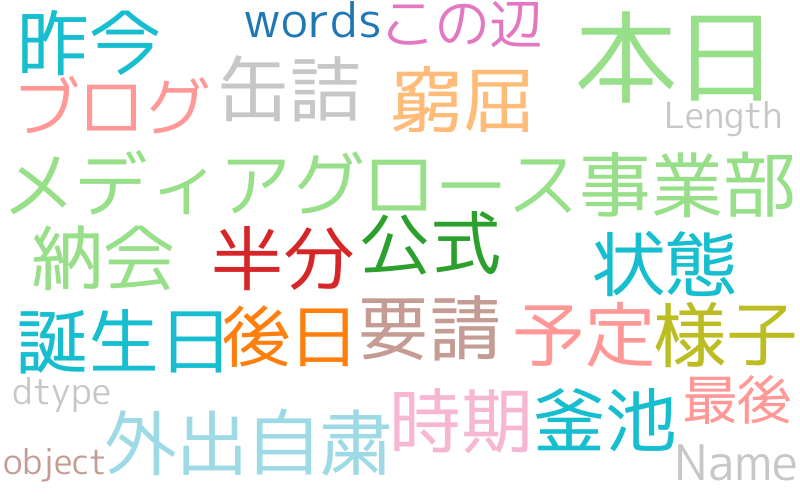

In [85]:
npt.wordcloud(
    stopwords=stopwords,
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    save=True
)

## 3-7. 共起ネットワーク

In [102]:
npt.build_graph(stopwords=stopwords, min_edge_frequency=13)

display(
    npt.node_df, npt.node_df.shape,
    npt.edge_df, npt.edge_df.shape
)

node_size:41, edge_size:31


,id,id_code,adjacency_frequency,betweeness_centrality,clustering_coefficient,community
0,未経験,0,2,0.012821,0.000000,0
1,メディア,1,1,0.000000,0.000000,1
2,インターン生,2,1,0.000000,0.000000,6
3,最先端,3,1,0.000000,0.000000,0
4,事業,4,3,0.030769,0.000000,1
5,地球,5,2,0.000000,1.000000,2
6,大切,6,1,0.000000,0.000000,8
7,社会,7,2,0.000000,1.000000,2
8,インターン,8,1,0.000000,0.000000,7
9,心理的,9,1,0.000000,0.000000,9


(41, 6)

,source,target,edge_frequency,source_code,target_code
0,インタビュー,メンバー,41,27,17
1,社会,貢献,24,7,40
2,マーケティング,世界,22,29,25
3,地球,社会,20,5,7
4,メディア,事業,19,1,4
5,入社,未経験,19,39,0
6,オンライン,気軽,19,16,12
7,価値,提供,19,22,37
8,マーケティング,最先端,19,29,3
9,コンテンツ,作成,18,30,33


(31, 5)

In [103]:
npt.co_network(
    title='All sentiment Co-occurrence network',
    color_palette='hls',
    save=True
)

## 3-8. sunburst chart

In [95]:
npt.sunburst(
    title='All sentiment sunburst chart',
    colorscale=True,
    color_continuous_scale='Oryel',
    width=800,
    height=600,
    save=True
)